# Inference Tasks on Stellar Spectra to Stellar Spectra

In [1]:
import torch
import numpy as np
import pylab as plt
from matplotlib.patches import Patch
from astroNN.shared.matplotlib import pylab_style

from stellarperceptron.model import StellarPerceptron

from utils.gaia_utils import (
    xp_coeffs_phys,
    nn_xp_coeffs_phys,
    xp_spec_online,
    xp_sampling_grid,
)

pylab_style(paper=True)

# ================== hardware-related settings ==================
device = "cpu"  # "cpu" for CPU or "cuda:x" for a NVIDIA GPU
mixed_precision = False
torch.backends.cuda.matmul.allow_tf32 = False
torch.backends.cudnn.allow_tf32 = False
# ================== hardware-related settings ==================

nn_model = StellarPerceptron.load(
    "./model_torch/", mixed_precision=mixed_precision, device=device
)

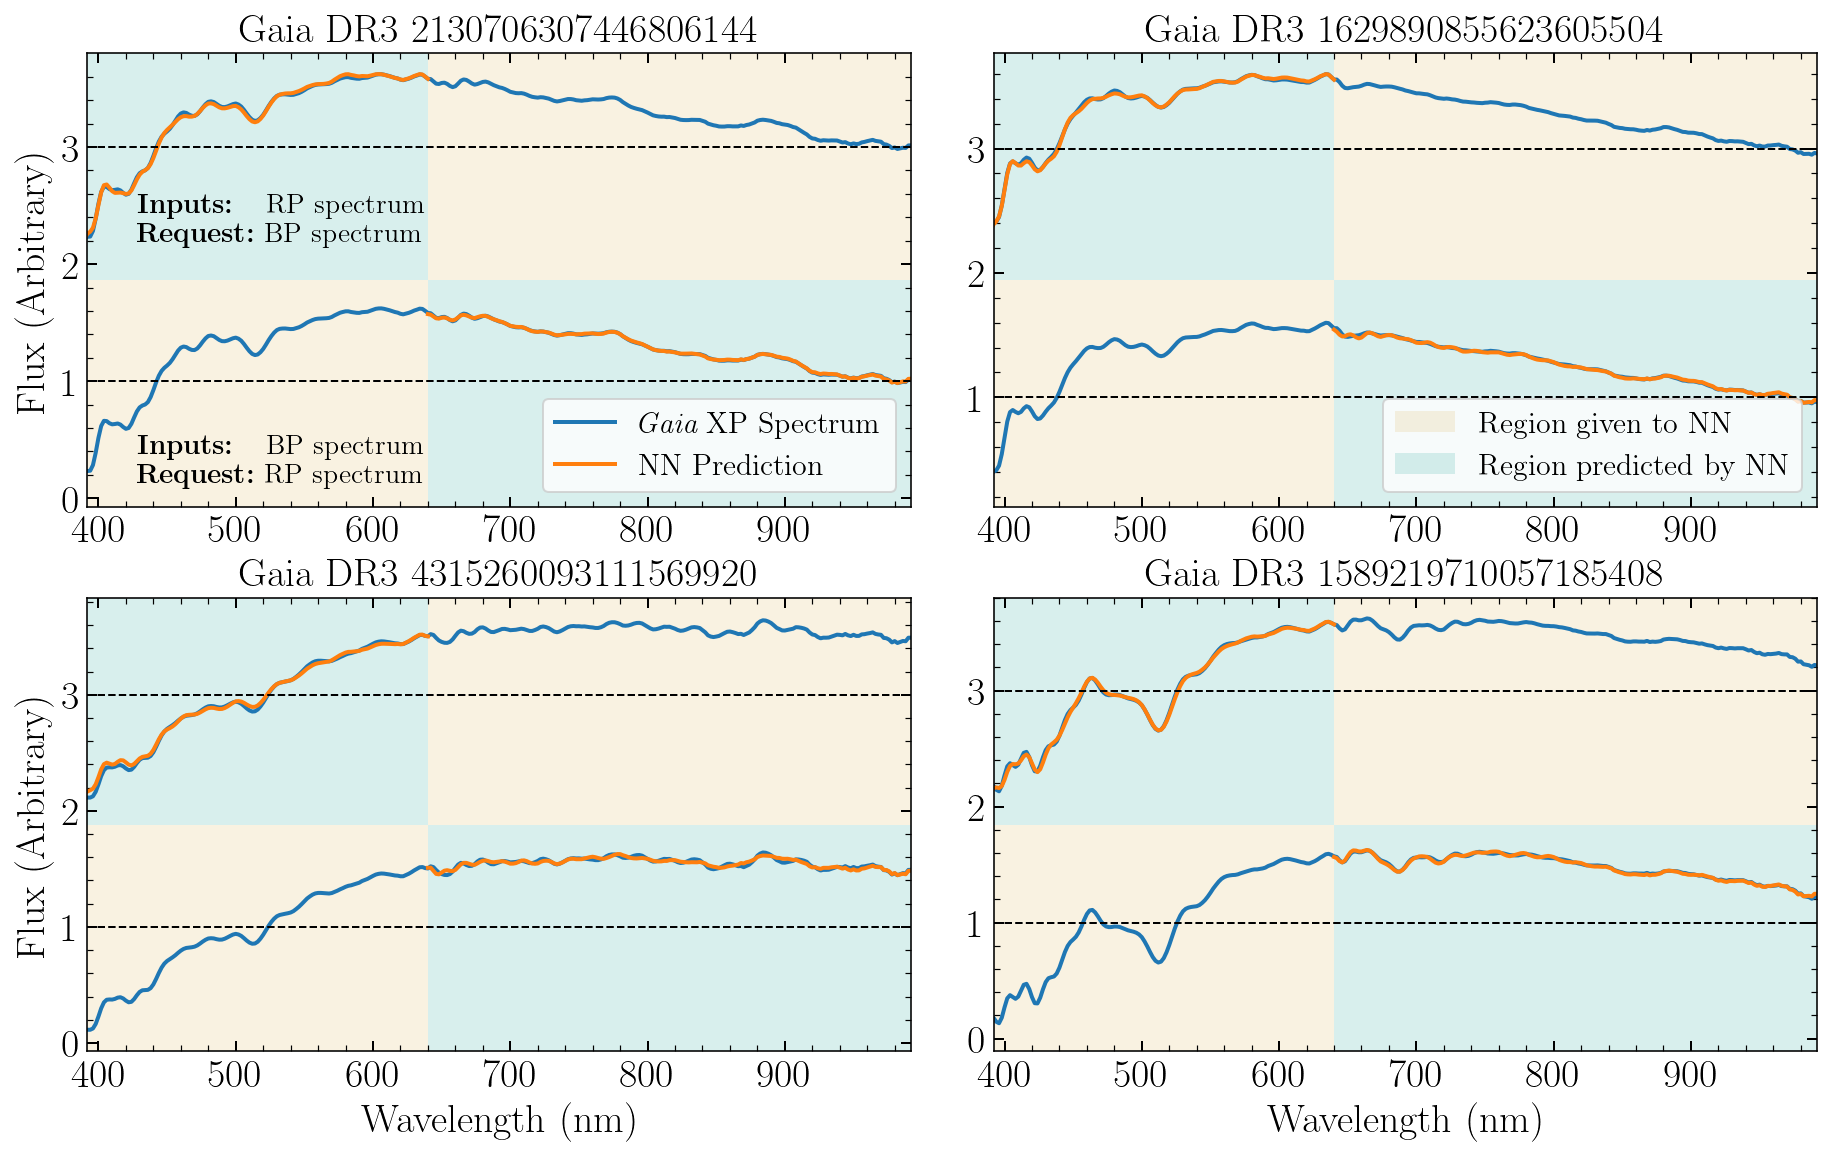

In [4]:
def plot_spec2spec(ax, gdr3_source_id, legend=True):
    bprp_coeffs = xp_spec_online(gdr3_source_id, absolute_flux=False)

    gaia_observed_spec = xp_coeffs_phys(bprp_coeffs)
    spectrum_1 = nn_xp_coeffs_phys(
        nn_model,
        **dict(zip([f"bp{i}" for i in range(52)], bprp_coeffs["bp"][:52])),
        absolute_flux=False,
    )
    nn_model.clear_perception()
    spectrum_2 = nn_xp_coeffs_phys(
        nn_model,
        **dict(zip([f"rp{i}" for i in range(52)], bprp_coeffs["rp"][:52])),
        absolute_flux=False,
    )
    nn_model.clear_perception()
    spectrum_1[xp_sampling_grid < 640] = np.nan
    spectrum_2[xp_sampling_grid > 640] = np.nan

    # colorblind friendly colors: https://davidmathlogic.com/colorblind
    ax.set_title(f"Gaia DR3 {gdr3_source_id}")
    ax.axvspan(0, 640, 0.0, 0.5, alpha=0.2, lw=0, color="#E1BE6A")
    ax.axvspan(0, 640, 0.5, 1.0, alpha=0.2, lw=0, color="#40B0A6")
    ax.axvspan(640, 9999, 0.0, 0.5, alpha=0.2, lw=0, color="#40B0A6")
    ax.axvspan(640, 9999, 0.5, 1.0, alpha=0.2, lw=0, color="#E1BE6A")
    ax.plot(
        xp_sampling_grid,
        gaia_observed_spec / 10**-21,
        lw=2,
        c="C0",
        label="$\\textit{Gaia}$ XP Spectrum",
    )
    ax.plot(xp_sampling_grid, gaia_observed_spec / 10**-21 + 2, lw=2, c="C0")
    ax.plot(xp_sampling_grid, spectrum_1 / 10**-21, lw=2, c="C1", label="NN Prediction")
    ax.plot(xp_sampling_grid, spectrum_2 / 10**-21 + 2, lw=2, c="C1")
    ax.axhline(1, ls="--", c="k", lw=1)
    ax.axhline(3, ls="--", c="k", lw=1)
    ax.set_xlabel("Wavelength (nm)")
    ax.set_ylabel("Flux (Arbitrary)")
    ax.set_xlim(392, 992)
    if legend:
        ax.legend(loc="lower right")


fig = plt.figure(figsize=(15.5, 9))
subfigs = fig.subfigures(1, 1)
((ax1, ax2), (ax3, ax4)) = subfigs.subplots(2, 2, gridspec_kw={"wspace": 0.1})

plot_spec2spec(ax1, 2130706307446806144)
ax1.set_xlabel(None)
ax1.annotate(
    "$\\textbf{Inputs:}$ $\\,$ $ $ RP spectrum\n$\\textbf{Request:}$ BP spectrum",
    xy=(0.06, 0.69),
    xycoords=ax1,
    fontsize=14,
    ha="left",
    va="top",
)
ax1.annotate(
    "$\\textbf{Inputs:}$ $\\,$ $ $ BP spectrum\n$\\textbf{Request:}$ RP spectrum",
    xy=(0.06, 0.16),
    xycoords=ax1,
    fontsize=14,
    ha="left",
    va="top",
)
plot_spec2spec(ax2, 1629890855623605504, legend=False)
legend_elements = [
    Patch(facecolor="#E1BE6A", alpha=0.2, label="Region given to NN"),
    Patch(facecolor="#40B0A6", alpha=0.2, label="Region predicted by NN"),
]
ax2.legend(handles=legend_elements, loc="lower right")
ax2.set_xlabel(None)
ax2.set_ylabel(None)
plot_spec2spec(ax3, 4315260093111569920, legend=False)
plot_spec2spec(ax4, 1589219710057185408, legend=False)
ax4.set_ylabel(None)

fig.savefig("./figs/spec2spec.pdf", bbox_inches="tight")